⏰ Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin edebilecek bir makine öğrenmesi modeli geliştirmek

⚓ Hedef değişken "outcome" 1 diyabet test sonucunun pozitif oluşunu 0 ise negatif oluşunu belirtmektedir.



⏰ Değişkenler

▶ Pregnancies: Hamilelik sayısı

▶ Glucose: Glikoz.

▶ BloodPressure: Kan basıncı.

▶ SkinThickness: Cilt Kalınlığı

▶ Insulin: İnsülin.

▶ BMI: Beden kitle indeksi.

▶ DiabetesPedigreeFunction: Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon.

▶ Age: Yaş (yıl)

▶ Outcome: Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0)

In [14]:
# kullanılacak kütüphanelri ayarlayalım

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report # plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate


In [15]:
import sklearn.metrics

In [16]:
# kullanacağımız bizim yazdığımız fonksiyonlar
# eşik değerleri hesaplamak  # çoğunlukla eşik değer oranı 0,25 -0,75 dir biz burada keskin bir traşlama yapmıyoruz
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [17]:
# aykırı değer var mı yok mu ?
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [18]:
# aykırı değerlerin baskılanması
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [19]:
# görüntü ayarlamalarını yapalım
pd.set_option("display.max_columns", None)
pd.set_option("Display.float_format", lambda x: "%.3f" %x)
pd.set_option("display.width", 500)

In [20]:
# veri setini okutup inceleyelim
df = pd.read_csv("/content/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [21]:
df.shape

(768, 9)

In [22]:
# target analizi : outcome 1 ve 0 değerlerinden oluşan bir kategorik değişken
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

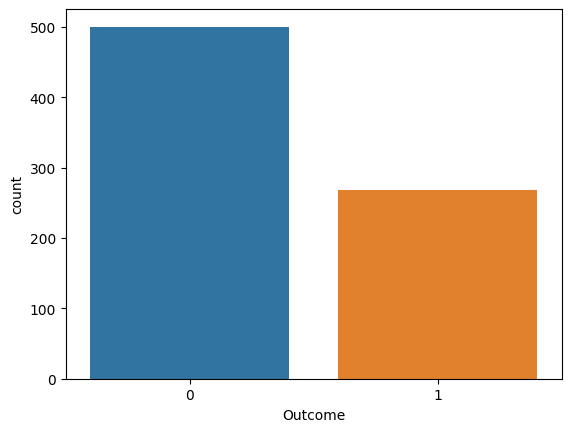

In [23]:
# ilgili değerleri görselleştirelim

sns.countplot(x="Outcome", data=df)
plt.show()

In [24]:
#ilgili dağılımın % olarak bulalım
df["Outcome"].value_counts()/ (len(df))*100

0   65.104
1   34.896
Name: Outcome, dtype: float64

In [25]:
# ya da
df["Outcome"].value_counts(normalize=True)*100

0   65.104
1   34.896
Name: Outcome, dtype: float64

💣 FEATURE ANALİZİ

In [26]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [27]:
# sayısal değişkenlerden bazılarına histogram grafiklte inceleyelim
def plot_numerical_col(dataframe, numerical_col):
  dataframe[numerical_col].hist(bins=10)
  plt.xlabel(numerical_col)
  plt.show()



In [28]:
cols = [col for col in df.columns if "Outcome" not in col]  # target ı grafikten çıkaralım

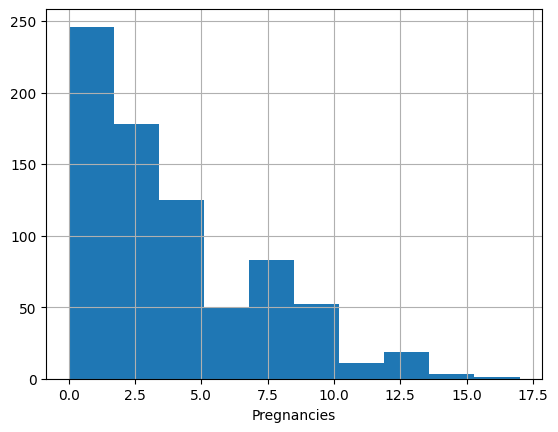

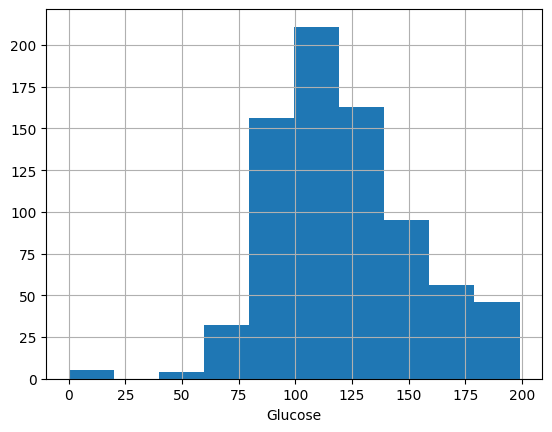

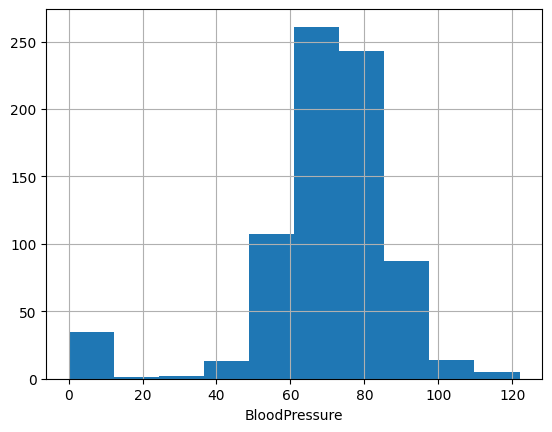

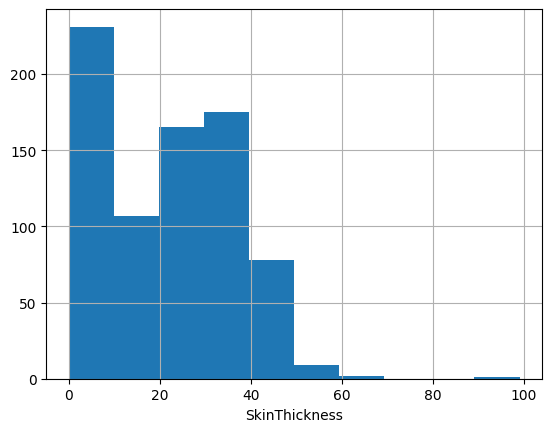

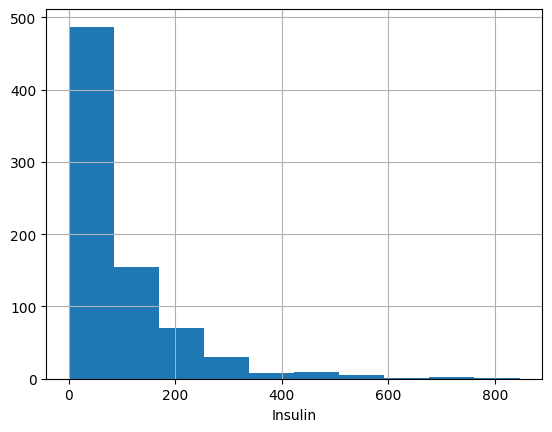

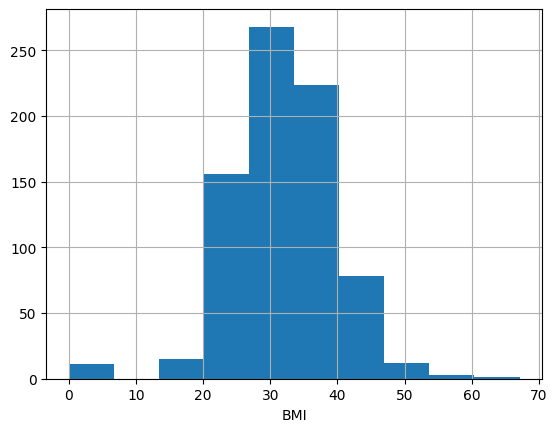

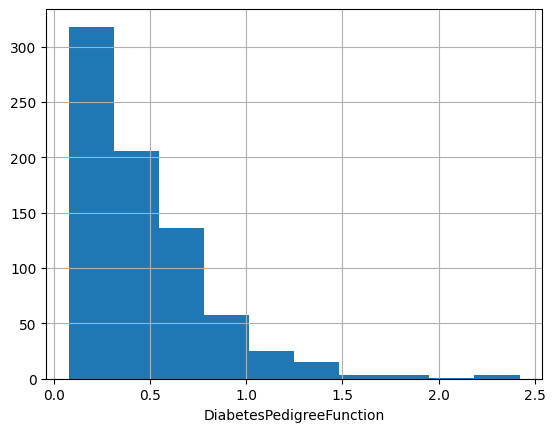

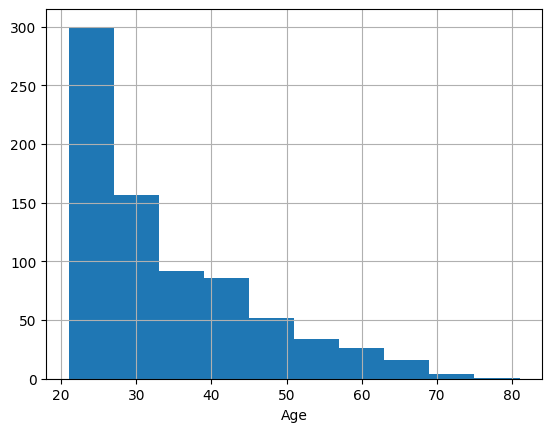

In [29]:
for col in cols:
  plot_numerical_col(df,col)


bu iki değer incelendiğinde göze çarpan 0 değerlerin olduğu ama canlı insanın kan basıncı ve/veya skinthickness değeri 0 olamaz. Muhtemelen null değerler 0 ile doldurulmuş

In [30]:
# Target vs Features
df.groupby("Outcome").agg({"Pregnancies":"mean"})


,Pregnancies
Outcome,
0,3.298
1,4.866


In [31]:
# target la ilişkiyi açıklayan bir fonksiyon tanımlayalım

def target_summary_with_num(dataframe, target, numerical_col):
  print(dataframe.groupby(target).agg({numerical_col: "mean"}))
  print("################################################")

In [32]:
for col in cols:
  target_summary_with_num(df, "Outcome",  col)

         Pregnancies
Outcome             
0              3.298
1              4.866
################################################
         Glucose
Outcome         
0        109.980
1        141.257
################################################
         BloodPressure
Outcome               
0               68.184
1               70.825
################################################
         SkinThickness
Outcome               
0               19.664
1               22.164
################################################
         Insulin
Outcome         
0         68.792
1        100.336
################################################
           BMI
Outcome       
0       30.304
1       35.143
################################################
         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550
################################################
           Age
Outcome       
0       31.190
1       37.0

 🎴  VERİ ÖN İŞLEME

In [33]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [34]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [35]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [36]:
# aykırı değer var mı yok mu bakalım
for col in cols:
  print(col, check_outlier(df, col))   # sadece insulinde aykırılık  var görünüyor

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


In [37]:
replace_with_thresholds(df, "Insulin")

In [38]:
for col in cols:
  print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


In [39]:
#standartlaştırma yapalım  robustscaler bütün gözlemlerin değerinden medyanı çıkarıp range değerine bölüyor
#standarScaler dan farkı aykırı değerlerden etkilenmiyor

for col in cols:
    df[col] = RobustScaler().fit_transform(df[[col]])

In [40]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235,1
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118,0
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176,1
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471,0
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235,1


🐗
⛹
💣
 MODELLEME



In [41]:
# bağımlı değişken y ile kalanlar x  ile
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [42]:
X.shape

(768, 8)

In [43]:
y.shape

(768,)

In [44]:
log_model = LogisticRegression().fit(X, y)

In [45]:
# bu modelin sabitlerine bakalım b değeri
log_model.intercept_[0]

-1.2343958783485596

In [46]:
# W değerleri 8 ayrı bileşen için
log_model.coef_

array([[ 0.59906785,  1.41770936, -0.23152362,  0.01973855, -0.14571255,
         0.81741997,  0.35522795,  0.25655154]])

In [47]:
# modele X ( bağımsız değişkenleri ) verelim ve ondan y_tshminleri alalım
y_pred = log_model.predict(X)

In [48]:
y[:5]

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [49]:
y_pred[:5]  # ilk 5 değer için doğru tahmin edilmiş. Şimdi tüm verileri kıyaslayarak modelimizin başarısını bulalım

array([1, 0, 1, 0, 1])

**🧲  MODEL BAŞARI DEĞERLENDİRMESİ**

In [50]:
# confision matrix i görselleştrecek fonksiyon yazalım
def plot_confusion_matrix(y, y_pred):
  acc = round(accuracy_score(y, y_pred), 2)  # acuracy : doğru sınıflandırma oranı
  cm = confusion_matrix(y, y_pred)  #
  sns.heatmap(cm, annot=True, fmt=".0f")
  plt.xlabel("y_pred")
  plt.ylabel("y")
  plt.title("Accuracy Score : {0}".format(acc), size=10)
  plt.show()

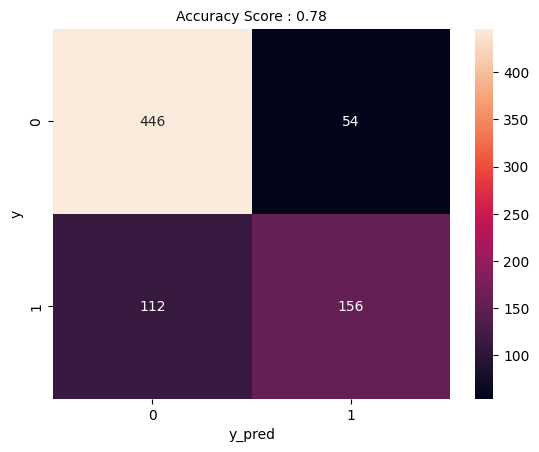

In [51]:
# fonksiyonu modelimizde deneyelim
plot_confusion_matrix(y, y_pred)

In [52]:
print(classification_report(y, y_pred))

# 1 olarak yaptığımız tahminlerin % 74 ü başarılı
# recall 1 olanları %58 başarıyla doğru sınıflandırdık

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



In [53]:
# farklı thresoldlara göre oluşan metrik
y_prob = log_model.predict_proba(X)[:,1]


In [54]:
roc_auc_score(y, y_prob)

0.8393955223880598

In [55]:
# modeli kurduğumuz veride yine modeli  test ettik


🧲 MODEL DOĞRULAMA

holdout yöntemiyle veriyi 2 ye böleceğin train ve test olarak

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)  # random state i aynı sonuçları almak için kullandık yani aynı %20 dilimde aynı veriler olacak

In [57]:
# train setinde modelimizi kuralım
log_model = LogisticRegression().fit(X_train, y_train)

In [58]:
# kurduğummuz modele modelin görmediği %20 lik x_test veri setini sorup tahminleri alalım
y_pred = log_model.predict(X_test)

In [59]:
# 1 sınıfına ait olma olasılıklarını hesaplayalım
y_prob = log_model.predict_proba(X_test)[:, 1]

In [60]:
y_prob[5]   # olasılık tahminlerinden biri

0.43013794157012986

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        97
           1       0.79      0.53      0.63        57

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.76       154



In [62]:
from sklearn.metrics import RocCurveDisplay


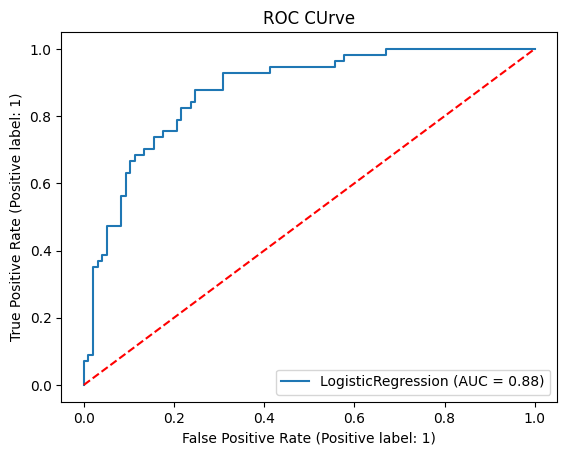

In [66]:
#  model başarısı ile ilgili grafik çizelim
# RocCurveDisplay.from_estimator(log_model, X_test, y_test)
plt.title("ROC CUrve")
plt.plot([0,1], [0,1],"r--")
plt.show()

daha önceki auc değeri 0,83 dü şimdiki modelde 0.88

💣 💣 💣

**10 katlı çapraz doğrulama **

In [67]:
# veri seti çok fazla veriden oluşmuyor o yüzden bütün veriyi kullanarak işlem yapalım
log_model = LogisticRegression().fit(X,y)

In [68]:
# 5 katlı yapalım
cv = cross_validate(log_model, X, y, cv=5, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [69]:
cv["test_accuracy"].mean()

0.7721925133689839

In [72]:
cv

{'fit_time': array([0.01019835, 0.00565076, 0.00533724, 0.0054841 , 0.00575447]),
 'score_time': array([0.01218104, 0.00935864, 0.01037145, 0.00948787, 0.00961709]),
 'test_accuracy': array([0.77272727, 0.74675325, 0.75324675, 0.81699346, 0.77124183]),
 'test_precision': array([0.71111111, 0.64705882, 0.71052632, 0.79069767, 0.73684211]),
 'test_recall': array([0.59259259, 0.61111111, 0.5       , 0.64150943, 0.52830189]),
 'test_f1': array([0.64646465, 0.62857143, 0.58695652, 0.70833333, 0.61538462]),
 'test_roc_auc': array([0.81277778, 0.80888889, 0.825     , 0.87339623, 0.84358491])}

daha önceki sonuçlara bakalım ⁉

Accuracy: 0.78
Precision: 0.74
Recall: 0.58
F1-score: 0.65



Accuracy: 0.77
Precision: 0.79
Recall: 0.53
F1-score: 0.63



son işlemin ortalamaları
accuracy :0.7721
precision: 0.7192
recall : 0.5747
f1 : 0.63
